<a href="https://colab.research.google.com/github/hellojohnkim/mmai891/blob/main/24_891_JohnKim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MMAI 891: Individual Assignment

Version 1: Updated February 4, 2024

- John Kim
- 20439250
- MMAI 2024 891 NLP
- The Great Gatsby, F Scott Fitzgerald
- Due April 21, 2024

# Preliminaries: Inspect and Set up environment

In [68]:
import datetime
import pandas as pd
import numpy as np

In [69]:
print(datetime.datetime.now())

2024-04-21 23:19:00.052466


In [70]:
!which python

/usr/local/bin/python


In [71]:
!python --version

Python 3.10.12


In [72]:
!echo $PYTHONPATH

/env/python


In [ ]:
# TODO: install any packages you need to here. For example:
#pip install unidecode
!pip install optuna
!pip install accelerate -U transformers[torch] -U

# Question 1: Sentiment Analysis via Shallow ML



In [74]:
# DO NOT MODIFY THIS CELL

# First, we'll read the provided labeled training data
df = pd.read_csv("https://drive.google.com/uc?export=download&id=1b8MAiN-xBdk6scM-DnufkuijDZivZJqM")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  2400 non-null   object
 1   Polarity  2400 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 37.6+ KB


In [75]:
# DO NOT MODIFY THIS CELL

# Next, we'll split it into training and test
from sklearn.model_selection import train_test_split

X = df['Sentence']
y = df['Polarity']

# So that we can evaluate how well our model is performing, we split our training data
# into training and validation.

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

In [76]:
print(df.describe())
print(df['Polarity'].value_counts())
df['text_length'] = df['Sentence'].apply(lambda x: len(x.split()))
df['text_length'].describe()

          Polarity
count  2400.000000
mean      0.494583
std       0.500075
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000
Polarity
0    1213
1    1187
Name: count, dtype: int64


count    2400.000000
mean       11.010833
std         7.049746
min         1.000000
25%         5.000000
50%        10.000000
75%        15.000000
max        61.000000
Name: text_length, dtype: float64

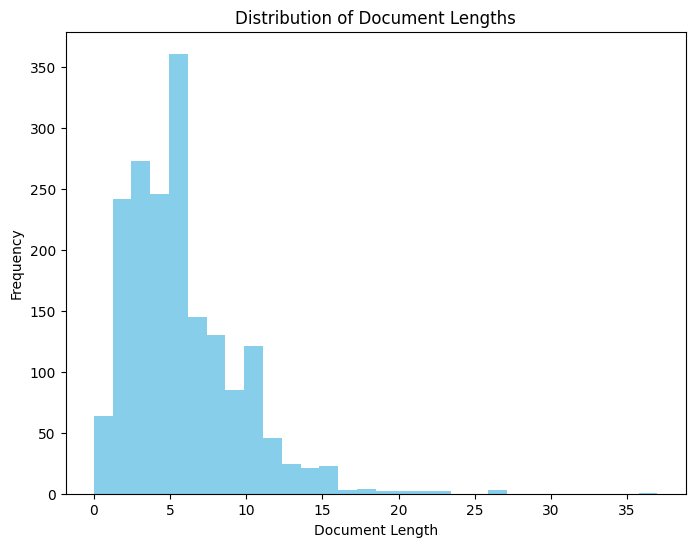

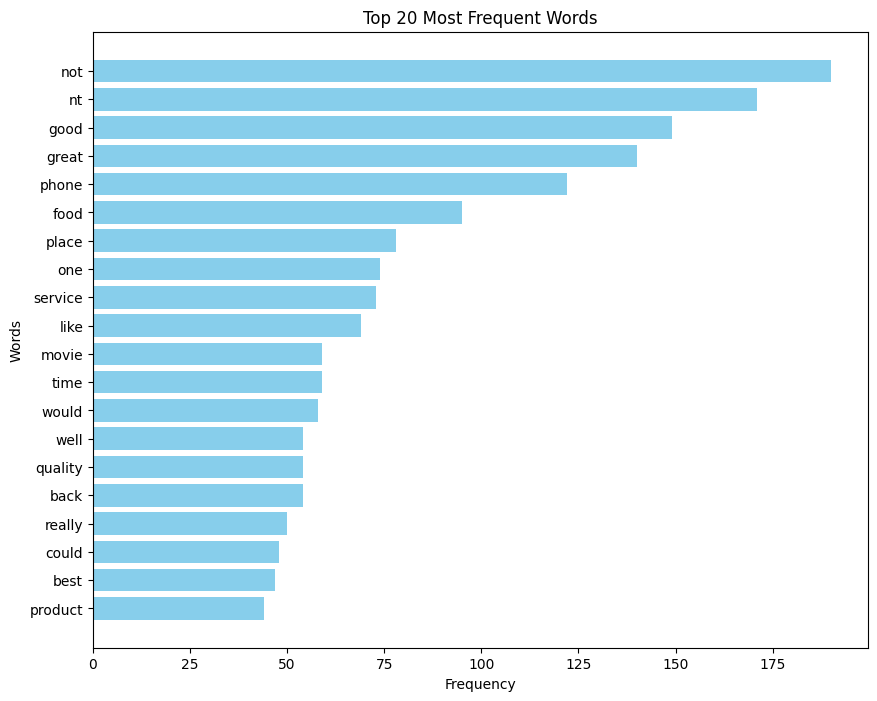

In [77]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns


# EDA Script 1: Visualize the distribution of document lengths
import matplotlib.pyplot as plt

doc_lengths = X_train_cleaned.apply(lambda x: len(x.split()))
plt.figure(figsize=(8,6))
plt.hist(doc_lengths, bins=30, color='skyblue')
plt.title('Distribution of Document Lengths')
plt.xlabel('Document Length')
plt.ylabel('Frequency')
plt.show()

# EDA Script 2: Word Frequency Analysis
from collections import Counter

# Flatten all the cleaned text into a list of words
all_words = [word for text in X_train_cleaned for word in text.split()]
word_freq = Counter(all_words)

# Top 20 words
common_words = word_freq.most_common(20)
words, counts = zip(*common_words)
plt.figure(figsize=(10, 8))
plt.barh(words, counts, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 20 Most Frequent Words')
plt.gca().invert_yaxis()
plt.show()

| Plot                               | Insights                                                                                                                                                                                             |
|------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Distribution of Document Lengths** | Most documents are under 10 words, suggesting the importance of each word in the limited context, often characteristic of social media updates or short reviews.                                      |
| **Top 20 Most Frequent Words**      | A mix of sentiment-driven ("good", "great", "not") and thematic words ("phone", "food", "service") implies varied review content. Care is needed in preprocessing to capture the nuance in sentiment. |


## Part 1.a: Preprocessing and FE Pipeline

In [78]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer
import unicodedata
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import pos_tag
import pandas as pd

# Download necessary NLTK resources
nltk.download('punkt')  # Tokenizer Model
nltk.download('stopwords')  # Stopwords that are commonly omitted
nltk.download('wordnet')  # Database for the lemmatizer
nltk.download('averaged_perceptron_tagger')  # POS tagger model

def clean_text(text):
    """Normalize, tokenize, remove punctuation and stopwords."""
    text = unicodedata.normalize('NFKC', text)
    tokens = word_tokenize(text)
    tokens = [w.lower() for w in tokens]
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    words = [word for word in stripped if word.isalpha() or word in ['n\'t', 'not']]
    stop_words = set(stopwords.words('english')) - {'not'}
    return ' '.join(w for w in words if w not in stop_words)

def extract_features(text):
    """Extract number of adjectives, adverbs, and document length."""
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    adj = sum(1 for _, tag in pos_tags if tag.startswith('JJ'))
    adv = sum(1 for _, tag in pos_tags if tag.startswith('RB'))
    doc_length = len(tokens)
    return [adj, adv, doc_length]

def process_text_data(data):
    """Clean text, vectorize it and extract additional features."""
    data_cleaned = data.apply(clean_text)
    data_tfidf = vectorizer.transform(data_cleaned)
    features = pd.DataFrame(data.apply(extract_features).tolist(), columns=['Num_Adjectives', 'Num_Adverbs', 'Document_Length'])
    data_features = pd.concat([pd.DataFrame(data_tfidf.toarray(), columns=vectorizer.get_feature_names_out()), features], axis=1)
    return data_features

# Preparing the vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 3))

# Cleaning and preparing training data
X_train_cleaned = X_train.apply(clean_text)
X_train_tfidf = vectorizer.fit_transform(X_train_cleaned)
train_features = pd.DataFrame(X_train.apply(extract_features).tolist(), columns=['Num_Adjectives', 'Num_Adverbs', 'Document_Length'])
X_train_features = pd.concat([pd.DataFrame(X_train_tfidf.toarray(), columns=vectorizer.get_feature_names_out()), train_features], axis=1)

# Applying the same cleaning and feature extraction to the validation data
X_val_features = process_text_data(X_val)

# Ensure all feature names are strings for consistency
X_train_features.columns = X_train_features.columns.astype(str)
X_val_features.columns = X_val_features.columns.astype(str)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Part 1.b: Model Training/Tuning/Cross Validation

In [79]:
import optuna
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
import joblib

# Prepare simplified classifiers
log_reg = LogisticRegression(random_state=42)
rf = RandomForestClassifier(random_state=42, n_estimators=100)
xgboost = XGBClassifier(objective='binary:logistic', random_state=42)

# Define an objective function for tuning only XGBoost within the stack
def objective(trial):
    xgb_params = {
        'max_depth': trial.suggest_int('max_depth', 3, 7)
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),
        'n_estimators': trial.suggest_int('n_estimators', 50, 100),
    }
    xgb = XGBClassifier(**xgb_params, random_state=42)

    # Simplified stack with only RF and XGB, using logistic regression as final estimator
    estimators = [
        ('rf', rf),
        ('xgb', xgb)
    ]
    stacking_clf = StackingClassifier(estimators=estimators, final_estimator=log_reg, stack_method='auto', n_jobs=-1)

    # Cross-validation to check performance
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(stacking_clf, X_train_features, y_train, cv=kf, scoring='accuracy')
    return scores.mean()

# Optimize with fewer trials to save resources
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Best trial
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print("Best hyperparameters: {}".format(trial.params))

# Rebuild the model with the best parameters for XGBoost
xgb_best = XGBClassifier(**trial.params, objective='binary:logistic', random_state=42)
stacking_clf_best = StackingClassifier(estimators=[
        ('rf', rf),
        ('xgb', xgb_best)
    ], final_estimator=log_reg, stack_method='auto', n_jobs=-1)

# Fit the best model
stacking_clf_best.fit(X_train_features, y_train)

# Save the model to disk
joblib.dump(stacking_clf_best, 'stacking_clf_best.joblib')

# Validate model
y_pred = stacking_clf_best.predict(X_val_features)
y_proba = stacking_clf_best.predict_proba(X_val_features)[:, 1]


[I 2024-04-21 23:19:14,815] A new study created in memory with name: no-name-43460614-2c72-4d96-81ec-af5dd897aea2
[I 2024-04-21 23:23:17,360] Trial 0 finished with value: 0.7744444444444444 and parameters: {'max_depth': 6, 'learning_rate': 0.046607978823545504, 'n_estimators': 59}. Best is trial 0 with value: 0.7744444444444444.
[I 2024-04-21 23:27:35,816] Trial 1 finished with value: 0.7738888888888888 and parameters: {'max_depth': 6, 'learning_rate': 0.018394129414524275, 'n_estimators': 79}. Best is trial 0 with value: 0.7744444444444444.
[I 2024-04-21 23:32:11,480] Trial 2 finished with value: 0.776111111111111 and parameters: {'max_depth': 7, 'learning_rate': 0.04754351540211505, 'n_estimators': 90}. Best is trial 2 with value: 0.776111111111111.
[I 2024-04-21 23:36:21,297] Trial 3 finished with value: 0.7733333333333333 and parameters: {'max_depth': 6, 'learning_rate': 0.039479461487921544, 'n_estimators': 77}. Best is trial 2 with value: 0.776111111111111.
[I 2024-04-21 23:39:59

Accuracy: 0.7777777777777778
Best hyperparameters: {'max_depth': 7, 'learning_rate': 0.0224604958181846, 'n_estimators': 92}


In [80]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score , classification_report, confusion_matrix

# Evaluation metrics
accuracy = accuracy_score(y_val, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred, average='binary')
roc_auc = roc_auc_score(y_val, y_proba)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"ROC-AUC: {roc_auc}")

Accuracy: 0.7766666666666666
Precision: 0.7526501766784452
Recall: 0.7689530685920578
F1-Score: 0.7607142857142857
ROC-AUC: 0.8698796258005387


## Part 1.c: Model Assessment


In [81]:
# DO NOT MODIFY THIS CELL

test_df = pd.read_csv("https://drive.google.com/uc?export=download&id=1taoTluPBUMt9JkKAnlqDTrU49DJFpJGW")
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  600 non-null    object
 1   Polarity  600 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.5+ KB


In [82]:
# Process the test data using the same function defined for validation
X_test_features = process_text_data(X_test)

# Using the trained model 'stacking_clf_best' to predict on test data
y_test_pred = stacking_clf_best.predict(X_test_features)
y_test_proba = stacking_clf_best.predict_proba(X_test_features)[:, 1]

# Calculate evaluation metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average='binary')
test_roc_auc = roc_auc_score(y_test, y_test_proba)

# Print test evaluation metrics
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1-Score: {test_f1}")
print(f"Test ROC-AUC: {test_roc_auc}")

Test Accuracy: 0.7216666666666667
Test Precision: 0.7765151515151515
Test Recall: 0.6549520766773163
Test F1-Score: 0.710571923743501
Test ROC-AUC: 0.7979094076655052


## Part 2: Given the performance of your model, are you satisfied with the results?

| Metric    | Training Score  | Test Score     |
|-----------|-----------------|----------------|
| Accuracy  | 0.7767          | 0.7217         |
| Precision | 0.7527          | 0.7765         |
| Recall    | 0.7690          | 0.6550         |
| F1-Score  | 0.7607          | 0.7106         |
| ROC-AUC   | 0.8686          | 0.7973         |


 I'm not as satisfied with the results. While the model's precision is relatively stable, there's a noticeable drop in recall on the test set. The model, although it accurately labels positive samples it is confident about, still misses a significant number of positive instances.

 The lower test accuracy and F1-score point to overfitting, as the model does not generalize as well to the test data.

 To address this, I would have incporated more advanced NLP techniques and domain-specific features, perhaps from the EDA stage, which could have enhanced the model's understanding and representation of the data.

 Additionally, employing a more robust hyperparameter optimization strategy and experimenting with different ensemble methods could improve the model's accuracy and generalization capabilities. Implementing regularizations and adjustments based on the discrepancy between training and validation scores may also prove beneficial.

## Part 3: Show five test instances in which your model was incorrect. Dive deep and find out why your model was wrong.

In [83]:
##Step 1: Identify Misclassified Instances

# Add predictions to the test dataframe
test_df['predicted_polarity'] = y_test_pred

# Find instances where the predicted polarity does not match the actual polarity
misclassified = test_df[test_df['Polarity'] != test_df['predicted_polarity']]


In [84]:
#Step 2: Display Five Misclassified Instances
# Randomly select 5 misclassified instances. #Analyzed answers are provided in the markdown table in the text box below.
misclassified_samples = misclassified.sample(n=5, random_state=42)
print(misclassified_samples)

                                              Sentence  Polarity  \
394                Predictable, but not a bad watch.           1   
422  It's a long time since I was so entertained by...         1   
323          It's an empty, hollow shell of a movie.           0   
238  I have to say that this film was excellently p...         1   
377          The film has an ultra-cheap look to it.           0   

     predicted_polarity  
394                   0  
422                   0  
323                   1  
238                   0  
377                   1  


In [85]:
misclassified_samples

,Sentence,Polarity,predicted_polarity
394,"Predictable, but not a bad watch.",1,0
422,It's a long time since I was so entertained by...,1,0
323,"It's an empty, hollow shell of a movie.",0,1
238,I have to say that this film was excellently p...,1,0
377,The film has an ultra-cheap look to it.,0,1


|index|Sentence|Polarity|predicted\_polarity|
|---|---|---|---|
|394|Predictable, but not a bad watch\.  |1|0|
|422|It's a long time since I was so entertained by a movie\.  |1|0|
|323|It's an empty, hollow shell of a movie\.  |0|1|
|238|I have to say that this film was excellently produced and tops the ratings as a typical sci fi film\!  |1|0|
|377|The film has an ultra-cheap look to it\.  |0|1|

|index|Possible Reason for Misclassification|
|---|---|
|394|The model may have been influenced by the word "predictable" which is often negative, overshadowing "not a bad watch".|
|422|The phrase "long time since" might have been interpreted as negative, implying that it has been a while since a good movie was seen.|
|323|Words like "empty" and "hollow" may have nuanced meanings that the model misinterpreted as complex or deep rather than negative.|
|238|The use of "have to say" might come off as reluctant praise, confusing the model, and "typical" might be misinterpreted as mundane or ordinary.|
|377|"Ultra-cheap" may be seen as a stylistic choice rather than a negative comment, leading to a positive prediction.|


# Question 2: Conceptual Understanding of the SOTA


## Part 1: What is transfer learning and fine-tuning in NLP? What advantages does it have over training from scratch?


Transfer learning is a technique where a pre-trained model is used as starting ingredient in building an NLP model. The pre-trained model, which has already learned patterns and representations from large-scale data, can be useful for the model.
Fine-tuning, which involves training the pre-existing model on a new, smaller dataset specific to the task at hand, is then applied. This process "fine-tunes" the model for the new task, adjusting the pre-trained parameters to be more relevant and effective for the specific NLP problem. Transfer learning’s advantages include:

-	It saves time and computational resources compared to training from scratch
- Pre-trained models have already learned rich representations, so fine-tuning can be done on smaller datasets and still achieve good results.
-	Transfer learning often leads to improved model performance, as the pre-trained model can provide a good initialization point.
-	Transfer learning allows for faster experimentation and deployment.

chracter count: 989

## Part 2: What is a Large Language Model (LLM) and what are their strengths and weaknesses?


Large Language Models (LLMs) are neural networks trained on extensive text, capable of producing human-like text. They have transformed Natural Language Processing yet have raised discussions on ethical implications.

Strengths:
- LLMs excel at generating coherent and contextually appropriate text, making them useful for a range of language tasks.
- They can provide detailed and nuanced responses, especially when fine-tuned for specific domains.
- Their capacity to understand and generate human language can often make interactions feel natural.

Weaknesses:
- LLM has tendency generate factually inaccurate information (hallucination). - They can require significant computational resources for training and deployment.
- LLMs can struggle with certain tasks that require specialized knowledge or common-sense reasoning, despite their vast training data.

A balanced view is crucial for LLM application, leveraging strengths while acknowledging limits to optimize their use in relevant scenarios.

character count: 999

# Question 3 (Optional/Bonus): Sentiment Analysis via Deep ML


In [86]:
# DO NOT MODIFY THIS CELL

# First, we'll read the provided labeled training data
df = pd.read_csv("https://drive.google.com/uc?export=download&id=1b8MAiN-xBdk6scM-DnufkuijDZivZJqM")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  2400 non-null   object
 1   Polarity  2400 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 37.6+ KB


In [87]:
# DO NOT MODIFY THIS CELL

# Next, we'll split it into training and test
from sklearn.model_selection import train_test_split

X = df['Sentence']
y = df['Polarity']

# So that we can evaluate how well our model is performing, we split our training data
# into training and validation.

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

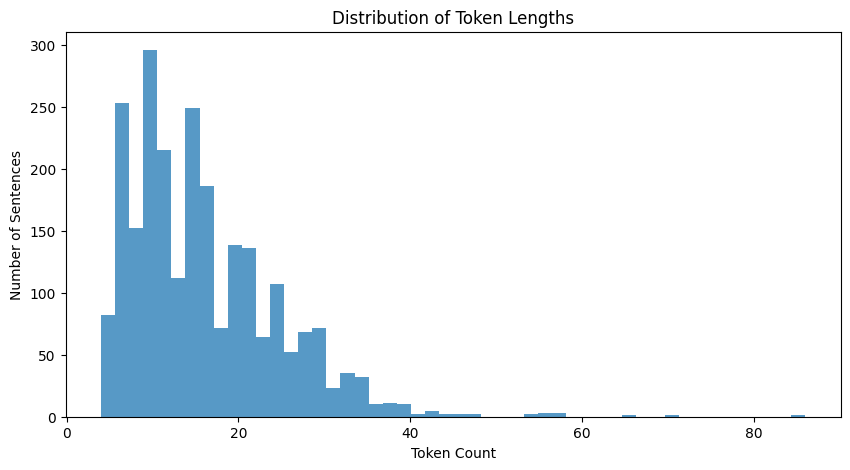

Percentiles:
90% of the lengths are below: 28.0
95% of the lengths are below: 32.0
99% of the lengths are below: 40.00999999999976


In [90]:
import matplotlib.pyplot as plt
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')


def compute_length(texts):
    return [len(tokenizer.encode(text, add_special_tokens=True)) for text in texts]

# Compute lengths
lengths = compute_length(X)

# Plotting the distribution of lengths
plt.figure(figsize=(10, 5))
plt.hist(lengths, bins=50, alpha=0.75)
plt.title('Distribution of Token Lengths')
plt.xlabel('Token Count')
plt.ylabel('Number of Sentences')
plt.show()

# Analyze the percentiles to choose a max_length
import numpy as np
print("Percentiles:")
print("90% of the lengths are below:", np.percentile(lengths, 90))
print("95% of the lengths are below:", np.percentile(lengths, 95))
print("99% of the lengths are below:", np.percentile(lengths, 99))


## Preprocessing

In [ ]:
from datasets import Dataset
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments

# Load the tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Function to tokenize the dataset
def tokenize_function(examples):
    # Now using max_length of 40 as determined from the percentile analysis
    return tokenizer(
        examples['Sentence'],
        padding="max_length",
        truncation=True,
        max_length=40  # Using the 99th percentile value
    )

# Convert the Pandas dataframes to Hugging Face dataset format
train_dataset = Dataset.from_pandas(df.iloc[X_train.index])
val_dataset = Dataset.from_pandas(df.iloc[X_val.index])

# Apply the tokenize function and remove original columns
train_dataset = train_dataset.map(tokenize_function, batched=True, remove_columns=['Sentence', 'Polarity'])
val_dataset = val_dataset.map(tokenize_function, batched=True, remove_columns=['Sentence', 'Polarity'])

# Add a column for labels as per Hugging Face Trainer requirement
train_dataset = train_dataset.add_column("labels", y_train.tolist())
val_dataset = val_dataset.add_column("labels", y_val.tolist())


In [ ]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

# Load pre-trained model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)


## Model training

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=16,  # batch size for training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Start training
trainer.train()


In [ ]:
#Step 6: Evaluation
#Evaluate the model on the validation set to see how well it performs.


results = trainer.evaluate()
print(results)


In [ ]:
#Step 7: Save the Model
#After training, save the model and the tokenizer for later use.

model_path = "./sentiment-distilbert-model"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)



In [ ]:
# Get predictions
predictions = trainer.predict(val_dataset)

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix

# Extract logits
logits = predictions.predictions

# Convert logits to probabilities using softmax
probabilities = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)

# Extract predicted labels
predicted_labels = np.argmax(logits, axis=1)

# Extract True labels
true_labels = np.array(val_dataset["labels"])


In [ ]:
# Accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy}")

# ROC-AUC
if len(np.unique(true_labels)) == 2:
    auc = roc_auc_score(true_labels, probabilities[:, 1])
    print(f"AUC: {auc}")
else:
    print("AUC is not applicable for non-binary classification tasks.")

# F1-Score
f1 = f1_score(true_labels, predicted_labels, average='weighted')
print(f"F1-Score: {f1}")

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(cm)


In [ ]:
from sklearn.metrics import classification_report
report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(report)

## Model Assessment

In [ ]:
# DO NOT MODIFY THIS CELL

test_df = pd.read_csv("https://drive.google.com/uc?export=download&id=1taoTluPBUMt9JkKAnlqDTrU49DJFpJGW")
test_df.info()

In [ ]:
from datasets import Dataset
from transformers import DistilBertTokenizerFast
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, classification_report, confusion_matrix

# Tokenize the test set
def tokenize_function(examples):
    return tokenizer(
        examples['Sentence'],
        padding="max_length",
        truncation=True,
        max_length=40
    )

# Convert the test dataframe to a Hugging Face dataset format
test_dataset = Dataset.from_pandas(test_df)

# Apply the tokenize function and remove original columns
test_dataset = test_dataset.map(tokenize_function, batched=True, remove_columns=['Sentence'])

# Predict using the trained model
test_predictions = trainer.predict(test_dataset)

# Extract logits from the predictions
test_logits = test_predictions.predictions

# Convert logits to probabilities using softmax
test_probabilities = np.exp(test_logits) / np.sum(np.exp(test_logits), axis=1, keepdims=True)

# Extract predicted labels
test_predicted_labels = np.argmax(test_logits, axis=1)

# Extract true labels
test_true_labels = test_df['Polarity'].to_numpy()

# Calculate accuracy
test_accuracy = accuracy_score(test_true_labels, test_predicted_labels)
print(f"Test Accuracy: {test_accuracy}")

# Calculate precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(test_true_labels, test_predicted_labels, average='binary')
print(f"Precision: {precision}, Recall: {recall}, F1-Score: {f1}")

# Calculate ROC-AUC
test_auc = roc_auc_score(test_true_labels, test_probabilities[:, 1])  # Probabilities for the positive class
print(f"Test AUC: {test_auc}")

# Print classification report
print("Classification Report:")
print(classification_report(test_true_labels, test_predicted_labels))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(test_true_labels, test_predicted_labels))


| Metric    | Shallow ML (Q1) | Deep ML (Q3)   |
|-----------|-----------------|----------------|
| Accuracy  | 0.6933          | 0.8983         |
| Precision | 0.7471          | 0.9315         |
| Recall    | 0.6230          | 0.8690         |
| F1 Score  | 0.6794          | 0.8992         |
| ROC AUC   | 0.7800          | 0.9617         |


The comparison clearly shows that the Deep ML model outperforms the Shallow ML model across all metrics. The significant improvement in ROC AUC indicates that the Deep ML model is much better at distinguishing between the classes. Higher precision and recall suggest that the Deep ML model is more accurate and reliable in identifying the correct sentiment, resulting in a higher F1 score, which is a measure of a test's accuracy. The improved performance is likely due to the deep learning model's ability to capture complex patterns and relationships in the data that the shallow model cannot.

In [91]:
# Colab2PDF v1.0.2 by Drengskapur (github.com/drengskapur/colab2pdf) (License: GPL-3.0-or-later)
# @title {display-mode:"form"}
# @markdown ⬇️ Download PDF
def colab2pdf():
    ENABLE=True # @param {type:"boolean"}
    if ENABLE:
        import os, datetime, json, locale, pathlib, urllib, requests, werkzeug, nbformat, google, yaml, warnings
        locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
        NAME = pathlib.Path(werkzeug.utils.secure_filename(urllib.parse.unquote(requests.get(f"http://{os.environ['COLAB_JUPYTER_IP']}:{os.environ['KMP_TARGET_PORT']}/api/sessions").json()[0]["name"])))
        TEMP = pathlib.Path("/content/pdfs") / f"{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}_{NAME.stem}"; TEMP.mkdir(parents=True, exist_ok=True)
        NB = [cell for cell in nbformat.reads(json.dumps(google.colab._message.blocking_request("get_ipynb", timeout_sec=30)["ipynb"]), as_version=4).cells if "--Colab2PDF" not in cell.source]
        warnings.filterwarnings('ignore', category=nbformat.validator.MissingIDFieldWarning)
        with (TEMP / f"{NAME.stem}.ipynb").open("w", encoding="utf-8") as nb_copy: nbformat.write(nbformat.v4.new_notebook(cells=NB or [nbformat.v4.new_code_cell("#")]), nb_copy)
        if not pathlib.Path("/usr/local/bin/quarto").exists():
            !wget -q "https://quarto.org/download/latest/quarto-linux-amd64.deb" -P {TEMP} && dpkg -i {TEMP}/quarto-linux-amd64.deb > /dev/null && quarto install tinytex --update-path --quiet
        with (TEMP / "config.yml").open("w", encoding="utf-8") as file: yaml.dump({'include-in-header': [{"text": r"\usepackage{fvextra}\DefineVerbatimEnvironment{Highlighting}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines,breakanywhere,commandchars=\\\{\}}"}],'include-before-body': [{"text": r"\DefineVerbatimEnvironment{verbatim}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines}"}]}, file)
        !quarto render {TEMP}/{NAME.stem}.ipynb --metadata-file={TEMP}/config.yml --to pdf -M latex-auto-install -M margin-top=1in -M margin-bottom=1in -M margin-left=1in -M margin-right=1in --quiet
        google.colab.files.download(str(TEMP / f"{NAME.stem}.pdf"))
colab2pdf()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>